In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
%matplotlib inline

We will use code from `exercise_session14_radioprotection`

<img src=" 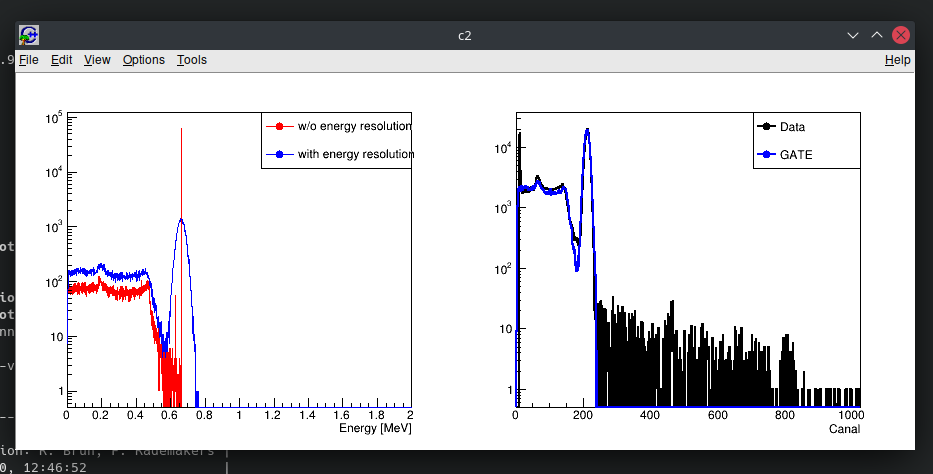" />

In [3]:
ls

 analyse/   output/
 data/     'Reproduce Root analyse.ipynb'
 help/     'Reproduce Root analyse-with-corrections.ipynb'
 mac/


In [7]:
!Gate mac/main.mac

plop
[G4] 
[G4] **************************************************************
[G4]  Geant4 version Name: geant4-10-06-patch-01    (14-February-2020)
[G4]                        Copyright : Geant4 Collaboration
[G4]                       References : NIM A 506 (2003), 250-303
[G4]                                  : IEEE-TNS 53 (2006), 270-278
[G4]                                  : NIM A 835 (2016), 186-225
[G4]                              WWW : http://geant4.org/
[G4] **************************************************************
[G4] 
[Core-0] Initialization of geometry
[Core-0] Initialization of physics
[Core-0] Initialization of actors
[Core-0] 
[Core-0] *************************************************
[Core-0]  GATE version 9.0 (March 2020)
[Core-0]  Copyright : OpenGATE Collaboration
[Core-0]  Reference : Phys. Med. Biol. 49 (2004) 4543-4561
[Core-0]  Reference : Phys. Med. Biol. 56 (2011) 881-901
[Core-0]  Reference : Med. Phys. 41(6)    (2014)
[Core-0]  http://www.opengatecol

      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
            ICRU73QO : Emin=    0 eV  Emax=    2 MeV  deltaVI
          BetheBloch : Emin=    2 MeV Emax=  100 TeV  deltaVI

hBrems:  for anti_proton  SubType=3
      dE/dx and range tables from 10 eV  to 100 TeV in 260 bins
      Lambda tables from threshold to 100 TeV, 20 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
               hBrem : Emin=    0 eV  Emax=  100 TeV
      ===== Limit on energy threshold has been applied 

hPairProd:  for anti_proton  SubType=4
      dE/dx and range tables from 10 eV  to 100 TeV in 260 bins
      Lambda tables from threshold to 100 TeV, 20 bins/decade, spline: 1
      Sampling table 17x1001; from 7.50618 GeV to 100 TeV 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
           hPairProd : Emin=    0 eV  Emax=  100 TeV

nuclearStopping:  for anti_proton applyCuts:1  SubType=8 BuildTable=0
      ===== EM mo

[Core-0] End of macro mac/main.mac
Graphics systems deleted.
Visualization Manager deleting...


In [8]:
ls output/

Energy.root  photons_statistic.txt


In [9]:
cat analyse/AnalyseRootFile.C

#include <TMath.h>
#include <TH1.h>
#include <TH2.h>
#include <TF1.h>
#include <TF2.h>
#include <TLegend.h>
#include <TROOT.h>
#include <TStyle.h>
#include <TCanvas.h>
#include <TRandom2.h>
#include <TFile.h>

void AnalyseRootFile() 
{	
  
  //NaI detector resolution (experimental)
  Double_t a = -1e-05;
  Double_t b = 0.08;
  Double_t c = 6.;
  TRandom2 *ran       = new TRandom2();

  
  //GATE
  //Get actor results
  TFile *f1 = new TFile("../output/Energy.root","read");
  TH1D *hEdep      = (TH1D *) f1->Get("edepHisto");

  //Create new histograms
  TH1F *hEdepCorr = new TH1F("hEdepCorr","hEdepCorr",2000,0,2);
  TH1D *hEdepCanal = new TH1D("hEdepCanal","hEdepCanal",1024,0,1024);
  TH1D *hCanal = new TH1D("hCanal","hCanal",1024,0,1024);

  //Add detector resolution and convert into canal
  for(int i=1;i < hEdep->GetNbinsX(); i++)
    {
      Double_t nE = hEdep->GetBinContent(i);
      Double_t Edep = i*0.5;

      //Loop on histograms bins
      for(int j = 0;j < nE; j++)
	{
	  
	  

In [10]:
#NaI detector resolution (experimental)
a = -1e-05;
b = 0.08;
c = 6.;

In [11]:
# TFile *f1 = new TFile("../output/Energy.root","read");
f1 = uproot.open("output/Energy.root")

In [12]:
#  TH1D *hEdep      = (TH1D *) f1->Get("edepHisto");
hEdep = f1.get("edepHisto")

What is type of `hEdep` ? 

In [13]:
type(hEdep)

uproot.dynamic.Model_TH1D_v2

Retrieve data from file into numpy arrays : 

In [14]:
values, bins = hEdep.to_numpy()

In [15]:
values

array([31., 60., 66., ...,  0.,  0.,  0.])

In [16]:
bins

array([0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 1.9990e+00, 1.9995e+00,
       2.0000e+00])

## plot hEdep

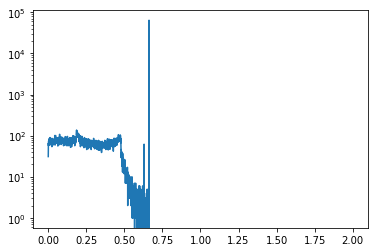

In [17]:
plt.plot(bins[:-1], values)
plt.yscale('log')

Reproduce algorithm in `AnalyseRootFile.C`

```c++
    //Add detector resolution and convert into canal
for(int i=1;i < hEdep->GetNbinsX(); i++)
{
  Double_t nE = hEdep->GetBinContent(i);
  Double_t Edep = i*0.5;
  //Loop on histograms bins
  for(int j = 0;j < nE; j++)
    {

      //Add detector resolution
      Double_t sigma_edep = (a*(Edep*Edep)+b*Edep+c)/2.37; //FWHM = 2.37xsigma = axE^2+bxE+c
      Double_t Edepcorr =  ran->Gaus(Edep,sigma_edep) ;

      //Convert into canal
      Double_t Edepcanal = (Edepcorr+12.)/3.18; // calibration linéaire

      //Fill histograms
      if(i>10)
        {
          hEdepCanal->Fill(Edepcanal); 
          hEdepCorr->Fill(Edepcorr/1000.);
        }
    }
}
```

In [18]:
import numpy.random

In [19]:
%%time
hEdepCanalValues = []
hEdepCorrVAlues = []
for i in range(len(values)):
    nE = values[i]
    Edep = i*0.5;
    #print(i, nE, Edep)
    for j in range(int(nE)):
        sigma_edep = (a*(Edep*Edep)+b*Edep+c)/2.37; #FWHM = 2.37xsigma = axE^2+bxE+c        
        Edepcorr = numpy.random.normal(Edep,sigma_edep)        
        # Convert into canal
        Edepcanal = (Edepcorr+12.)/3.18; # calibration linéaire
        if i>10:
            hEdepCanalValues.append(Edepcanal)
            hEdepCorrVAlues.append(Edepcorr / 1000.)

CPU times: user 321 ms, sys: 27.9 ms, total: 349 ms
Wall time: 348 ms


Text(0.5, 0, 'Energy [MeV]')

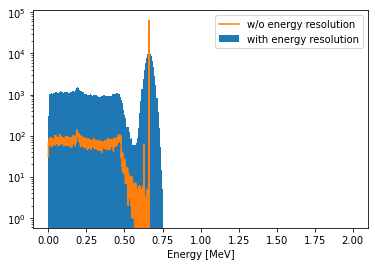

In [20]:
plt.hist(hEdepCorrVAlues, bins=100, label = "with energy resolution");
values, bins = hEdep.to_numpy()
plt.plot(bins[:-1], values, label="w/o energy resolution")
plt.yscale('log')
plt.legend(loc="best")
plt.xlabel("Energy [MeV]")

Text(0.5, 0, 'Energy [MeV]')

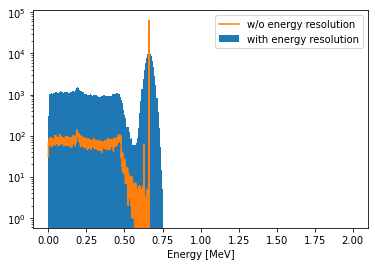

In [21]:
plt.hist(hEdepCorrVAlues, bins=100, label = "with energy resolution");
values, bins = hEdep.to_numpy()
plt.plot(bins[:-1], values, label="w/o energy resolution")
plt.yscale('log')
plt.legend(loc="best")
plt.xlabel("Energy [MeV]")

## Optimize it !

In [22]:
values.size

4000

In [23]:
%%time
hEdepCorrVAlues = []
for i, nE in enumerate(values):
    if i <= 10:
        continue
    
    #nE = values[i]
    Edep = i*0.5;
    #print(i, nE, Edep)
    sigma_edep = (a*(Edep*Edep)+b*Edep+c)/2.37; #FWHM = 2.37xsigma = axE^2+bxE+c     
    Edepcorr = numpy.random.normal(Edep,sigma_edep, size = int(nE))                
    
    
    hEdepCorrVAlues.append(Edepcorr)
    

hEdepCorrVAlues = np.hstack(hEdepCorrVAlues)    
hEdepCanalValues = (hEdepCorrVAlues+12.)/3.18; # calibration linéaire
hEdepCorrVAlues /= 1000.

CPU times: user 23.9 ms, sys: 11.9 ms, total: 35.8 ms
Wall time: 33.9 ms


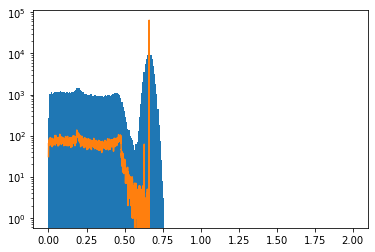

In [24]:
plt.hist(hEdepCorrVAlues, bins=100);
values, bins = hEdep.to_numpy()
plt.plot(bins[:-1], values)
plt.yscale('log')

## Make the second plot

Open expermental data

```c++
 //Genie2000 (experimental measurements)  
  TH1F *hGenie2K = new TH1F("hGenie2K","hGenie2K",1024,0,1024);
  string parametersline;
  std::ifstream fin("137Cs_2cm_5min_bdfsoustr.txt");
  Int_t count = 0.;
  int nbin = 0;
  while(getline(fin,parametersline))
    {
      sscanf(parametersline.c_str(),"%d",&count);
      if(nbin > 10) hGenie2K->Fill(nbin,count);
      nbin+=1;
    }
```

In [25]:
!head analyse/137Cs_2cm_5min_bdfsoustr.txt

Open data with only pyhton code

In [26]:
%%time
hGenie2KValues = []
hGenie2KBins = []
with open("analyse/137Cs_2cm_5min_bdfsoustr.txt", 'rt') as f:
    for i, line in enumerate(f):               
        if i > 10:
            hGenie2KValues.append(float(line))
            hGenie2KBins.append(float(i))
        

CPU times: user 4.36 ms, sys: 1.26 ms, total: 5.62 ms
Wall time: 3.79 ms


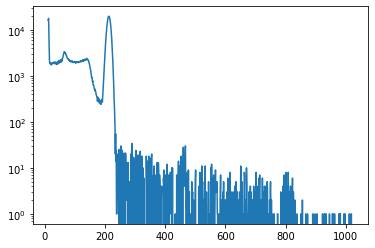

In [27]:
plt.plot(hGenie2KBins, hGenie2KValues)
plt.yscale('log')

The same but with `numpy` function

In [28]:
hGenie2KValues = np.loadtxt("analyse/137Cs_2cm_5min_bdfsoustr.txt")
hGenie2KBins = np.arange(hGenie2KValues.size)
hGenie2KValues = hGenie2KValues[10:]
hGenie2KBins = hGenie2KBins[10:]

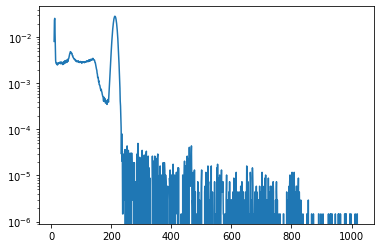

In [29]:
plt.plot(hGenie2KBins, hGenie2KValues / hGenie2KValues.sum())
plt.yscale('log')

```c++
//Normalize to maximum
  hCanal->Scale(hGenie2K->GetMaximum()/hCanal->GetMaximum());
  hEdepCanal->Scale(hGenie2K->GetMaximum()/hEdepCanal->GetMaximum());
```

Text(0.5, 0, 'Canal')

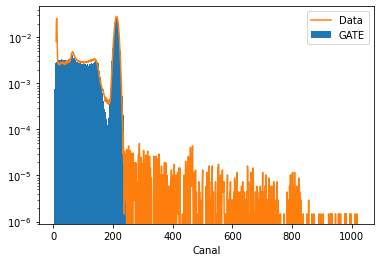

In [30]:
plt.hist(hEdepCanalValues, bins=100, density=True, log=True, label = "GATE");
plt.plot(hGenie2KBins, hGenie2KValues / hGenie2KValues.sum(), label = "Data");
plt.legend(loc='best');
plt.xlabel("Canal")

# Final plot

Make the two plots one one figure

Text(0.5, 0, 'Canal')

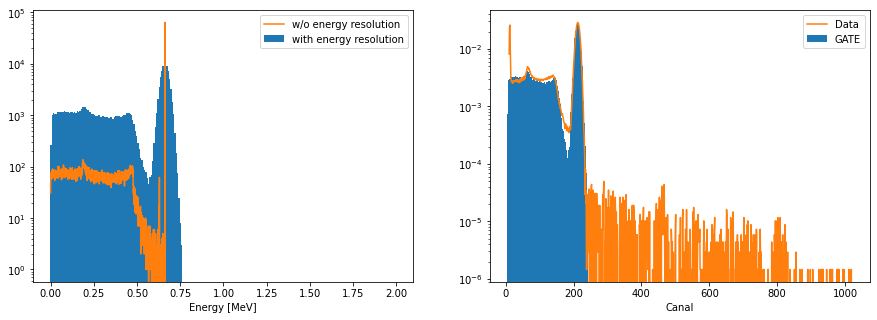

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(hEdepCorrVAlues, bins=100, label = "with energy resolution");
values, bins = hEdep.to_numpy()
plt.plot(bins[:-1], values, label="w/o energy resolution")
plt.yscale('log')
plt.legend(loc="best")
plt.xlabel("Energy [MeV]")
plt.subplot(1,2,2)
plt.hist(hEdepCanalValues, bins=100, density=True, log=True, label = "GATE");
plt.plot(hGenie2KBins, hGenie2KValues / hGenie2KValues.sum(), label = "Data");
plt.legend(loc='best');
plt.xlabel("Canal")